## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

VERSION_DICTS = [
    ('reference', {'current': '2020_06_18.28',
                   'sub3': '2020_06_18.32'}),
    ('ensemble', {'current': '2020_06_18.29',
                  'sub3': '2020_06_18.30'})
]


## Methods

In [2]:
def summarize_date(model_type, data_type, version, date_df=None):
    df = pd.read_csv(f'/ihme/homes/rmbarber/covid-19/elastispliner/{version}/model_results_refit.csv')
    df = df.loc[df['location_id'] != 102]

    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['location_id', 'date'])
    first_date = (df['date'] == df.groupby('location_id')['date'].transform(min)).values

    draw_cols = [col for col in df.columns if col.startswith('draw_')]
    daily = np.diff(df[draw_cols], axis=0, prepend=np.nan)
    daily[first_date] = df.loc[first_date, draw_cols].values
    df[draw_cols] = daily

    if date_df is None:
        df['last_date'] = df.groupby('location_id')['date'].transform(max)
        keep_idx = df.apply(lambda x: x['date'] > x['last_date'] - pd.Timedelta(days=7), axis=1)
        df = df.loc[keep_idx]
        del df['last_date']
        date_df = df[['location_id', 'date']].copy()
    else:
        df = df.merge(date_df)

    df = df.groupby('location_id', as_index=False)[draw_cols].sum()
    df[f'{data_type}_deaths'] = df[draw_cols].mean(axis=1)
    df[f'{data_type}_deaths_ui_range'] = np.percentile(df[draw_cols], 97.5, axis=1) - np.percentile(df[draw_cols], 2.5, axis=1)
    df[f'{data_type}_deaths_ui_relative'] = df[f'{data_type}_deaths_ui_range'] / df[f'{data_type}_deaths']
    
    df['model_type'] = model_type

    df = df[['location_id', 'model_type',
             f'{data_type}_deaths', 
             f'{data_type}_deaths_ui_range', f'{data_type}_deaths_ui_relative']]

    return df, date_df


def get_data(model_type, version_dict):
    sub3_df, date_df = summarize_date(
        model_type=model_type,
        data_type='sub3',
        version=version_dict['sub3'],
        date_df=None
    )
    current_df, _ = summarize_date(
        model_type=model_type,
        data_type='current',
        version=version_dict['current'],
        date_df=date_df
    )
    df = current_df.merge(sub3_df)

    return df


## Produce data

In [3]:
dfs = []
for model_type, version_dict in VERSION_DICTS:
    df = get_data(model_type, version_dict)
    dfs.append(df)
df = pd.concat(dfs)


## Plot

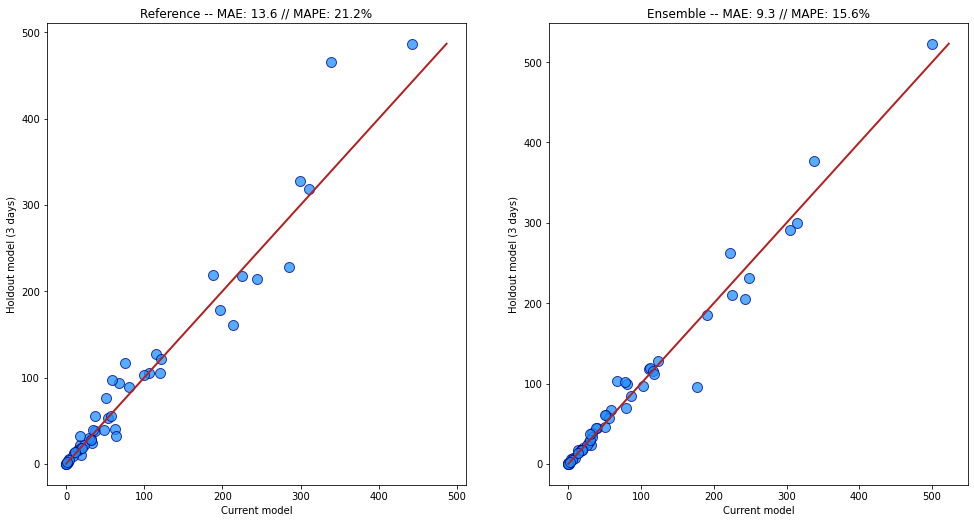

In [6]:
measure='deaths'

fig, ax = plt.subplots(1, 2, figsize=(16.5, 8.5))

for i, mt in enumerate(['reference', 'ensemble']):
    data = df.loc[df['model_type'] == mt, [f'current_{measure}', f'sub3_{measure}']].values
    data_error = np.abs(np.diff(data, axis=1))
    pct_error = data_error / data[:,[0]]

    mean_abs_error = np.round(np.mean(data_error), 1)
    mean_pct_abs_error = np.round(np.mean(pct_error) * 100, 1)
    
    plot_title = f'{mt.title()} -- MAE: {mean_abs_error} // MAPE: {mean_pct_abs_error}%'
    
    ax[i].scatter(df.loc[df['model_type'] == mt, f'current_{measure}'],
                  df.loc[df['model_type'] == mt, f'sub3_{measure}'],
                  c='dodgerblue', edgecolors='navy', alpha=0.75, s=100)
    ax[i].plot((data.min(), data.max()), 
               (data.min(), data.max()),
               color='firebrick', linewidth=2)
    ax[i].set_xlabel('Current model')
    ax[i].set_ylabel('Holdout model (3 days)')
    ax[i].set_title(plot_title)
plt.show()
